# 概要

遺伝子でない特徴量と遺伝子特徴量を組み合わせてEDAを行う

In [1]:
import os
import itertools
import warnings
import math
from tqdm import tqdm
import numpy as np
import pandas as pd

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr
from boruta import BorutaPy

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file
import config
import functions

functions.fix_seed(config.SEED)

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [3]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
# check(df_clinical)
df_clinical.shape

(2509, 36)

## カラムの順序変更（読みやすさのため）

In [4]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [5]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_EDA_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床データの読み込み

In [6]:
df_MB = pd.read_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")

## 遺伝子データの読み込み

In [7]:
# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()

"""
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()
"""
pass

KeyboardInterrupt: 

# 臨床データのEDA

## 各特徴毎の再発期間の確認

サブグループ毎に再発した患者の割合・晩年再発・カプランマイヤー曲線を確認する

In [ ]:
# functions.check(df_MB)

In [ ]:
df_MB.dropna(subset="RFS_STATUS", inplace=True)

### recurrence patient num

In [ ]:
df_MB.RFS_STATUS.value_counts()

In [ ]:
df_MB[df_MB["RFS_STATUS"] == "1:Recurred"].groupby("CLAUDIN_SUBTYPE").count()

In [ ]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] <= 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count()

In [ ]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] > 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count()

we need to sqweeze our data by RFS MONTHS>=5*12 or not

In [ ]:
df_MB.RFS_MONTHS.hist(bins=20)

In [ ]:
df_MB[df_MB.RFS_MONTHS > 5 * 12].shape

## 全体の再発期間のばらつき

In [ ]:
year = 5
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
print((df_tmp.RFS_MONTHS > 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print((df_tmp.RFS_MONTHS <= 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print((df_tmp.RFS_MONTHS > 12 * year).sum())

### 分布ヒストグラム

In [ ]:
df_MB.RFS_MONTHS.hist(bins=int(math.log2(df_MB.shape[0])), label="all data")
plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")

0:Not Reccured -> 初診から最終フォローアップまでの期間なので注意

In [ ]:
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
df_tmp.RFS_MONTHS.hist(bins=int(math.log2(df_tmp.shape[0])), label="0:Not Reccured")
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
df_tmp.RFS_MONTHS.hist(bins=int(math.log2(df_tmp.shape[0])), label="1:Recurred")
plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")

### KM lineの描画
全体の再発期間の可視化のためにカプランマイヤー曲線を描画

**打ち切り**
右側打ち切り：再発なし患者  
左側打ち切り：なし（今回のデータでは初診からすでに再発している患者がいるか不明なため）  

**注意点**
RFS_MONTHSは再発者であれば初診～再発の期間を示すが、非再発者であれば初診から最終フォローアップまでの期間を示している。  

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

df_tmp = df_MB[["RFS_MONTHS", "RFS_STATUS"]]
df_tmp = df_tmp.replace({"0:Not Recurred": False, "1:Recurred": True})
kmf = KaplanMeierFitter()
kmf.fit(durations=df_tmp.RFS_MONTHS, event_observed=df_tmp.RFS_STATUS)
kmf.plot()

ax.set_xlabel("RFS_MONTHS")
ax.set_ylabel("RECURRENCE PATIENT RATE")
ax.axvline(5 * 12)
ax.axvline(10 * 12)
ax.axvline(15 * 12)
plt.xlim(0, 350)
plt.ylim(0, 1.0)
plt.show()

In [ ]:
def EDA_subgroup_relations(subgroup_name: str, year: int):
    # 統計情報
    print("欠損値数：", df_MB[subgroup_name].isna().sum())
    df_recurred = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
    print("再発者/全患者")
    print(
        df_recurred[subgroup_name].value_counts() / df_MB[subgroup_name].value_counts()
    )
    print("{0}年以内再発者/全再発者".format(year))
    print(
        df_recurred[df_recurred.RFS_MONTHS <= 12 * year][subgroup_name].value_counts()
        / df_recurred[subgroup_name].value_counts()
    )
    print("{0}年以後再発者/全再発者".format(year))
    print(
        df_recurred[df_recurred.RFS_MONTHS > 12 * year][subgroup_name].value_counts()
        / df_recurred[subgroup_name].value_counts()
    )

    # カプランマイヤー曲線可視化
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot()

    for subgroup in df_MB[subgroup_name].unique():
        if type(subgroup) != str:
            continue
        df_subgroup = df_MB[df_MB[subgroup_name] == subgroup][
            ["RFS_MONTHS", "RFS_STATUS"]
        ]
        df_subgroup = df_subgroup.replace({"0:Not Recurred": False, "1:Recurred": True})
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=df_subgroup.RFS_MONTHS,
            event_observed=df_subgroup.RFS_STATUS,
            label=subgroup,
        )
        kmf.plot(ci_show=False)
    ax.set_xlabel("RFS_MONTHS")
    ax.set_ylabel("RECURRENCE PATIENT RATE")
    ax.axvline(5 * 12)
    ax.axvline(10 * 12)
    ax.axvline(15 * 12)
    plt.title(subgroup_name)
    plt.xlim(0, 350)
    plt.ylim(0, 1.0)
    plt.show()
    del df_recurred, df_subgroup

## サブグループの特徴がカテゴリ変数の場合

### CLAUDIN_SUBTYPE

注目したい要因

In [ ]:
EDA_subgroup_relations("CLAUDIN_SUBTYPE", 5)

### その他の要因（注目度低）

In [ ]:
EDA_subgroup_relations("ONCOTREE_CODE", 5)
# ER, HER2
EDA_subgroup_relations("ER_STATUS", 5)
EDA_subgroup_relations("ER_IHC", 5)
EDA_subgroup_relations("HER2_STATUS", 5)
EDA_subgroup_relations("HER2_SNP6", 5)
EDA_subgroup_relations("PR_STATUS", 5)
# その他のサブタイプ
EDA_subgroup_relations("THREEGENE", 5)
EDA_subgroup_relations("HISTOLOGICAL_SUBTYPE", 5)
# 治療法
EDA_subgroup_relations("HORMONE_THERAPY", 5)
EDA_subgroup_relations("RADIO_THERAPY", 5)
EDA_subgroup_relations("BREAST_SURGERY", 5)
EDA_subgroup_relations("CHEMOTHERAPY", 5)

## サブグループの特徴が数値データの場合（カテゴリ化する必要がある）

### NPI
ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index  

In [ ]:
print("欠損値数：", df_MB.NPI.isna().sum())
print("最小値：", df_MB.NPI.min(), " 最大値：", df_MB.NPI.max())
plt.xlim(1, int(df_MB.NPI.max() + 1))
df_MB.NPI.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
year = 5
df_MB["NPI_CAT"] = pd.cut(
    df_MB.NPI,
    [0, 2.0, 2.4, 3.4, 5.4, np.inf],
    labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
)

EDA_subgroup_relations("NPI_CAT", 5)

### 腫瘍サイズ

乳癌のステージの定義：https://oshiete-gan.jp/breast/diagnosis/stages/detail.html

腫瘍サイズ0mm/20mm/50mmで区切るのがよさそう？

In [ ]:
print("欠損値数：", df_MB.TUMOR_SIZE.isna().sum())
print("最小値：", df_MB.TUMOR_SIZE.min(), " 最大値：", df_MB.TUMOR_SIZE.max())
df_MB.TUMOR_SIZE.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
year = 5
df_MB["TUMOR_CAT"] = pd.cut(
    df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
)

EDA_subgroup_relations("TUMOR_CAT", 5)

### リンパ節陽性数

層別化ソース：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

In [ ]:
print("欠損値数：", df_MB.LYMPH_NODES_EXAMINED_POSITIVE.isna().sum())
print(
    "最小値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.min(),
    " 最大値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.max(),
)
df_MB.LYMPH_NODES_EXAMINED_POSITIVE.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
print(
    "1/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.25),
    " 1/2分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.5),
    " 3/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.75),
)

In [ ]:
year = 5
df_MB["LYMPH_CAT"] = pd.cut(
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
    [-np.inf, 0, 3, np.inf],
    labels=["0", "1~3", "4~inf"],
)

EDA_subgroup_relations("LYMPH_CAT", 5)

### その他の要因（注目度低）

In [ ]:
print("欠損値数：", df_MB.GRADE.isna().sum())
print(
    "最小値：",
    df_MB.GRADE.min(),
    " 最大値：",
    df_MB.GRADE.max(),
)
df_MB.GRADE.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
df_MB["GRADE_CAT"] = pd.cut(
    df_MB.GRADE,
    [0, 1, 2, 3],
    labels=[
        "1",
        "2",
        "3",
    ],
)

EDA_subgroup_relations("GRADE_CAT", 5)

df_MB["TMB_CAT"] = pd.qcut(
    df_MB.TMB_NONSYNONYMOUS, [0, 0.1, 0.9, 1], labels=["c1", "c2", "c3"]
)

EDA_subgroup_relations("TMB_CAT", 5)

# 遺伝子発現量データのEDA

## 各マイクロアレイ手法毎の確認

mrna_agilent_microarrayとmrna_agilent_microarray_zscores_ref_all_samplesの遺伝子は完全に一致しているが、mrna_agilent_microarray_zscores_ref_diploid_samplesはそれら2つとは違う（特徴量数が不足している）ことを確認済み

# 再発者のみのデータのEDA

2-preprocess_RFSノートブックから、前処理をして再発者に限定したdf: df_recurrencedを取り出す

In [ ]:
# 臨床データ（層別化対象）と遺伝子データが結合されており、再発者に限定されている

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)

## 再発までの期間と遺伝子発現量の相関の確認

In [1]:
drop_columns = [
    "RFS_OVER_60MONTHS",
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]
# サブクラス情報を削除
df_recurrenced_gene_expressions = df_recurrenced.drop(drop_columns, axis=1)

# 前処理後の再発者に限定した患者の、各遺伝子と再発までの期間の相関係数
corr=pd.merge(
    df_recurrenced_gene_expressions, df_MB.RFS_MONTHS, left_index=True, right_index=True
).corr()

NameError: name 'df_recurrenced' is not defined

# クラスタリング

## 次元削減

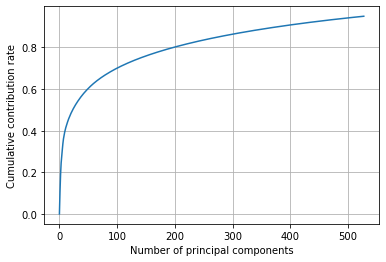

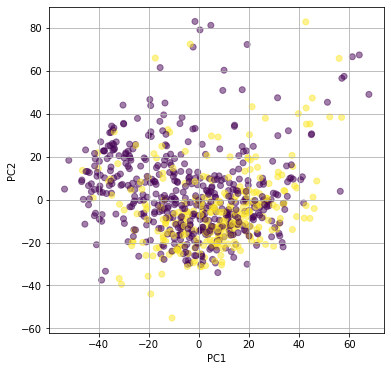

In [67]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker

# 通常のPCA
pca = PCA(n_components=0.95)

df_gene_expressions = df_mrna_agilent_microarray.copy()
reduced_data = pca.fit_transform(df_recurrenced[df_gene_expressions.columns])

plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    alpha=0.5,
    c=list(df_recurrenced["RFS_OVER_60MONTHS"]),
)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=config.SEED)
kmeans.fit(df_recurrenced[df_gene_expressions.columns])

KMeans(n_clusters=2, random_state=100)

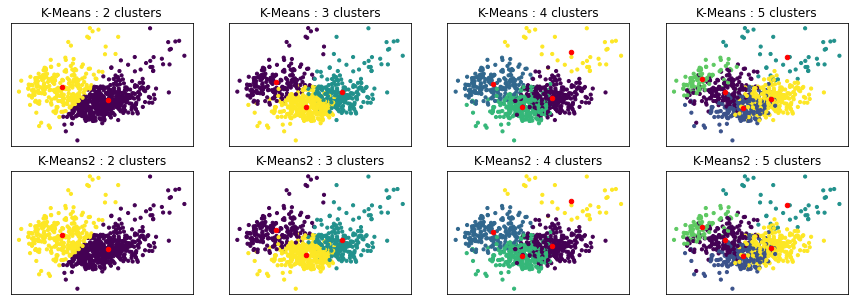

In [64]:
from sklearn.cluster import  KMeans

X=df_recurrenced[df_gene_expressions.columns].copy()

# Number of cluster centers for KMeans and BisectingKMeans
n_clusters_list = [2, 3, 4, 5]

# Algorithms to compare
clustering_algorithms = {
    "K-Means": KMeans,
    "K-Means2": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(15, 5)
)

axs = axs.T

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters, random_state=config.SEED)
        algo.fit(reduced_data)
        centers = algo.cluster_centers_
        axs[j, i].scatter(reduced_data[:, 0], reduced_data[:, 1], s=10, c=algo.labels_)
        axs[j, i].scatter(centers[:, 0], centers[:, 1], c="r", s=20)
        axs[j, i].set_title(f"{algorithm_name} : {n_clusters} clusters")


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()